# IS 362 Final Project: Electric Vehicle (EV) Adoption Analysis

### Project Overview
This project investigates the relationship between Electric Vehicle (EV) adoption rates and two primary factors:

1. **Median Household Income**   
    A measure of the economic capacity required to afford EVs

2. **Charging Station Density**   
    A measure of infrastructure availability that supports EV adoption

The project uses publicly available datasets from the U.S. Census Bureau, the National Renewable Energy Laboratory (NREL), and the Alternative Fuels Data Center (AFDC).
All datasets are cleaned, standardized, joined, stored in a relational database, and then used to calculate adoption rates, infrastructure density, correlations, and visualizations.

### Section 1: Library Imports and Setup

This section loads all required Python libraries for the project.
They support:

1. Data extraction from APIs and spreadsheet files
2. Data manipulation and cleaning using pandas and NumPy
3. Statistical calculations using SciPy
4. Visualization using Matplotlib, Seaborn, and Plotly
5. Database operations using SQLite3

To improve readability and consistency:

1. pandas display options are configured to show all columns
2. seaborn styling is applied to produce cleaner graphs

This section ensures the project environment is fully prepared for data processing and analysis.

In [7]:
import sqlite3
import requests
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time

# Configure pandas display options for better readability
pd.set_option("display.max_columns", None)

# Set visual style for charts
sns.set_style=("whitegrid")

### Section 2: Database Setup

To maintain a structured and reproducible workflow, a SQLite database is created to store three core datasets:
1. **ev_registrations**: State-level EV registration counts
2. **charging_stations**: Individual charging station records by state
3. **census_data**: State population and median income data

Structuring datasets in a relational database improves clarity and supports future queries or expansions of the analysis.

In [8]:
# Connect to or create the SQLite database file
conn = sqlite3.connect("ev_project.db")
cursor = conn.cursor()

# Table for Electric Vehicle Registrations
cursor.execute("""CREATE TABLE IF NOT EXISTS ev_registrations (
                    state TEXT,
                    ev_count INTEGER
                )""")

# Table for Public Charging Stations
cursor.execute("""CREATE TABLE IF NOT EXISTS charging_stations (
                    id INTEGER PRIMARY KEY,
                    state TEXT,
                    station_name TEXT
                )""")

# Table for Census Socioeconomic Data
cursor.execute("""CREATE TABLE IF NOT EXISTS census_data (
                    state TEXT,
                    population INTEGER,
                    median_income INTEGER
                )""")

conn.commit()

### Section 3: Raw Data Acquisition from External Sources

This section retrieves and prepares raw data from three independent sources:

1. EV registration counts (AFDC Excel)
2. Public charging station data (NREL API)
3. Population and median income (2024 ACS Census API)

A state abbreviation lookup table is also imported to support merging.

##### 3.1 EV Registration Data (AFDC)

This subsection loads state-level EV registration counts from the Alternative Fuels Data Center (AFDC). Key steps include:

1. Cleaning the raw Excel file by removing extra header rows and unused columns.
2. Renaming fields to standardized column names for consistency.
3. Converting EV registration counts into numeric format to ensure valid calculations.
4. Preparing the dataset so it can later be merged with Census and infrastructure data.

This dataset forms the core input for estimating EV adoption rates across states.

In [9]:
# Load AFDC EV registration dataset
ev_df = pd.read_excel("ADFC-10962-ev-registration-counts-by-state_9-06-24.xlsx")

# Rename and clean columns
ev_df = ev_df.rename(columns={"Unnamed: 1": "state_name", "Unnamed: 2": "ev_registrations"})
ev_df = ev_df.iloc[2:].reset_index(drop=True)

# Convert EV count to numeric
ev_df["ev_registrations"] = pd.to_numeric(ev_df["ev_registrations"], errors="coerce")

# Drop irrelevant metadata columns
ev_df = ev_df.drop(columns=["Unnamed: 0", "Unnamed: 3", "Unnamed: 4"])
ev_df.head()

,state_name,ev_registrations
0,Alabama,13047
1,Alaska,2697
2,Arizona,89798
3,Arkansas,7108
4,California,1256646


#### 3.2 Charging Station Data (NREL API)

This section retrieves charging station data from the National Renewable Energy Laboratory (NREL) API. The API provides detailed information about public charging stations nationwide. The workflow includes:

1. Downloading current station records filtered for public, electric-only stations.
2. Renaming and cleaning fields to align with the project’s schema.
3. Aggregating individual station records to compute state-level counts.

These totals allow calculation of charging station density, an important indicator of infrastructure availability.

In [22]:
API_KEY = "U8U9h7bh76Vavoa9dYwSzc2iUZsjHeqGuObh6Tar" 
url = f"https://developer.nrel.gov/api/alt-fuel-stations/v1.csv?api_key={API_KEY}&fuel_type=ELEC&access=public&status=E"
stations_df = pd.read_csv(url, low_memory=False)

stations_df.head()

,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,Expected Date,Groups With Access Code,Access Days Time,Cards Accepted,BD Blends,NG Fill Type Code,NG PSI,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV Other Info,EV Network,EV Network Web,Geocode Status,Latitude,Longitude,Date Last Confirmed,ID,Updated At,Owner Type Code,Federal Agency ID,Federal Agency Name,Open Date,Hydrogen Status Link,NG Vehicle Class,LPG Primary,E85 Blender Pump,EV Connector Types,Country,Intersection Directions (French),Access Days Time (French),BD Blends (French),Groups With Access Code (French),Hydrogen Is Retail,Access Code,Access Detail Code,Federal Agency Code,Facility Type,CNG Dispenser Num,CNG On-Site Renewable Source,CNG Total Compression Capacity,CNG Storage Capacity,LNG On-Site Renewable Source,E85 Other Ethanol Blends,EV Pricing,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source,Restricted Access,RD Blends,RD Blends (French),RD Blended with Biodiesel,RD Maximum Biodiesel Level,NPS Unit Name,CNG Station Sells Renewable Natural Gas,LNG Station Sells Renewable Natural Gas,Maximum Vehicle Class,EV Workplace Charging,Funding Sources
0,ELEC,Los Angeles Convention Center,1201 S Figueroa St,West hall and South hall,Los Angeles,CA,90015.0,NaN,213-741-1151,E,NaN,Public,5:30am-9pm; pay lot,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,Non-Networked,NaN,GPS,34.040539,-118.271387,2023-01-10,1523,2025-11-19 18:59:41 UTC,P,NaN,NaN,1995-08-30,NaN,NaN,NaN,NaN,J1772,US,NaN,NaN,NaN,Public,NaN,public,NaN,NaN,PARKING_GARAGE,NaN,NaN,NaN,NaN,NaN,NaN,Free,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN
1,ELEC,Scripps Green Hospital,10666 N Torrey Pines Rd,"Patient Parking Structure, level G",La Jolla,CA,92037.0,NaN,NaN,E,NaN,Public,24 hours daily,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Non-Networked,NaN,GPS,32.899470,-117.243000,2024-08-15,6355,2025-02-12 00:16:32 UTC,P,NaN,NaN,1997-07-30,NaN,NaN,NaN,NaN,J1772,US,NaN,NaN,NaN,Public,NaN,public,NaN,NaN,HOSPITAL,NaN,NaN,NaN,NaN,NaN,NaN,Free; parking fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2,ELEC,Galpin Motors,15421 Roscoe Blvd,NaN,Sepulveda,CA,91343.0,NaN,855-889-2811,E,NaN,Public - Call ahead,Dealership business hours; customer use only,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,Non-Networked,NaN,200-9,34.221665,-118.468371,2025-06-06,6405,2025-06-06 18:42:11 UTC,P,NaN,NaN,2012-12-11,NaN,NaN,NaN,NaN,J1772,US,NaN,NaN,NaN,Public - Appeler à l'avance,NaN,public,CALL,NaN,CAR_DEALER,NaN,NaN,NaN,NaN,NaN,NaN,Free,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MD,False,NaN
3,ELEC,Galleria at Tyler,1299 Galleria at Tyler,NaN,Riverside,CA,92503.0,NaN,951-351-3110,E,NaN,Public,6am-12am daily,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Non-Networked,NaN,GPS,33.909914,-117.459053,2023-09-14,6425,2025-05-16 15:00:13 UTC,P,NaN,NaN,1997-08-30,NaN,NaN,NaN,NaN,J1772,US,NaN,NaN,NaN,Public,NaN,public,NaN,NaN,SHOPPING_MALL,NaN,NaN,NaN,NaN,NaN,NaN,Free,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN
4,ELEC,City of Pasadena - Holly Street Garage,150 E Holly St,NaN,Pasadena,CA,91103.0,NaN,626-744-7665,E,NaN,Public,24 hours daily; pay lot,CREDIT,NaN,NaN,NaN,NaN,26.0,NaN,NaN,Non-Networked,NaN,200-8,34.147620,-118.147111,2025-06-06,6505,2025-07-17 16:07:56 UTC,LG,NaN,NaN,2014-01-20,NaN,NaN,NaN,NaN,J1772,US,NaN,NaN,NaN,Public,NaN,public,NaN,NaN,PARKING_GARAGE,NaN,NaN,NaN,NaN,NaN,NaN,Free,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN


#### 3.3 Socioeconomic Data (2024 ACS Census)

This section retrieves and prepares the 2024 American Community Survey (ACS) socioeconomic indicators that support the interpretation of EV adoption patterns across states. The ACS data provides two core variables that add essential context to EV registration trends:

1. Population estimates, which allow EV registrations to be normalized relative to the size of each state's population.
2. Median household income, which helps assess how economic capacity may influence EV adoption rates and affordability.

These indicators strengthen the analysis by ensuring EV registration counts are evaluated alongside demographic and economic characteristics that meaningfully impact adoption patterns.

In [11]:
census_url_2024 = (
    "https://api.census.gov/data/2024/acs/acs1?"
    "get=NAME,B01003_001E,B19013_001E&for=state:*"
)

census_json = requests.get(census_url_2024).json()
census_df_2024 = pd.DataFrame(census_json[1:], columns=census_json[0])

# Rename columns for readability
census_df_2024 = census_df_2024.rename(columns={
    "NAME": "state_name",
    "B01003_001E": "population",
    "B19013_001E": "median_income"
})

# Convert population and median income to numeric
census_df_2024["population"] = census_df_2024["population"].astype(int)
census_df_2024["median_income"] = census_df_2024["median_income"].astype(int)

census_df_2024.head()

,state_name,population,median_income,state
0,Alabama,5157699,66659,01
1,Alaska,740133,95665,02
2,Arizona,7582384,81486,04
3,Arkansas,3088354,62106,05
4,California,39431263,100149,06


#### 3.4 State Abbreviation Table

This subsection introduces a helper lookup table that standardizes state identifiers across datasets. It ensures seamless joining of data through:

1. Mapping full state names to USPS two-letter abbreviations.
2. Resolving naming inconsistencies between Census, AFDC, and NREL datasets.
3. Creating a reliable merge key that aligns all data sources.

This step prevents merge errors and maintains data integrity throughout the analysis.

In [12]:
state_abbrev = pd.read_csv(
    "https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv"
)
state_abbrev = state_abbrev.rename(columns={
    "State": "state_name",
    "Abbreviation": "state" 
})

state_abbrev.head()

,state_name,state
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


### Section 4: Data Cleaning and Merging

This section prepares the datasets for analysis by standardizing state identifiers, merging EV counts, merging charging station counts, and integrating census data.

#### Section 4.1: Standardizing and Merging State Identifiers
This step ensures that all datasets use consistent state identifiers so they can be merged correctly.
The Census API provides full state names, while other datasets rely on two-letter state abbreviations.
To resolve this mismatch:

1. Census data is merged with a state abbreviation lookup table.
2. EV registration data is cleaned and matched to the same abbreviation format.
3. Non-matching or missing entries are removed to maintain data integrity.

This produces two standardized datasets:
one containing population and income, and the other containing EV registration counts.

In [ ]:
# Merge census with state abbreviations
merged_census_df = census_df_2024.merge(state_abbrev, on="state_name", how="left")
merged_census_df = merged_census_df.drop(columns=["state_name", "state_x"]) 
merged_census_df = merged_census_df.rename(columns={"state_y": "state"}) 
merged_census_df = merged_census_df.dropna(subset=["state"]) 

# Prepare EV registration data
ev_df = ev_df.rename(columns={"state": "state_name"})
ev_df = ev_df.merge(state_abbrev, on="state_name", how="left")
ev_df = ev_df.drop(columns=["state_name"])
ev_df = ev_df.dropna(subset=["state", "ev_registrations"])
ev_df = ev_df.rename(columns={"ev_registrations": "ev_count"})

ev_df.head()

,ev_count,state
0,13047,AL
1,2697,AK
2,89798,AZ
3,7108,AR
4,1256646,CA


#### Section 4.2: Aggregating Charging Station Data

Each row in the NREL station dataset represents one charging station location.
To analyze infrastructure availability at the state level, this step:
1. Standardizes the state column name.
2. Groups all station records by state.
3. Counts the total number of public charging stations in each state.

The result is a compact table where each state is associated with its total number of public charging stations.

In [ ]:
# Aggregate charging station counts by state
stations_df = stations_df.rename(columns={"State": "state"})
stations_aggregated = stations_df.groupby("state").agg(
    total_stations=("ID", "count")
).reset_index()

stations_aggregated.head()

,state,total_stations
0,AK,71
1,AL,544
2,AR,379
3,AZ,1505
4,CA,18960


#### Section 4.3: Creating the Final Integrated Analysis Table

This step merges all cleaned and standardized datasets into a single analysis dataframe.
It combines:
1. Population and income data
2. EV registration counts
3. Total public charging station counts

Using inner joins ensures only states present in all datasets are included.
This integrated dataframe forms the foundation for computing EV adoption rates, station density, correlations, and visualizations later in the project.

In [ ]:
# Merge all datasets into a single analysis table
analysis_df_2024 = merged_census_df.merge(ev_df, on="state", how="inner")
analysis_df_2024 = analysis_df_2024.merge(stations_aggregated, on="state", how="inner")

analysis_df_2024.head()

,population,median_income,state,ev_count,total_stations
0,5157699,66659,AL,13047,544
1,740133,95665,AK,2697,71
2,7582384,81486,AZ,89798,1505
3,3088354,62106,AR,7108,379
4,39431263,100149,CA,1256646,18960


### Section 5: Feature Engineering

This section creates two derived variables to enhance the analysis and allow for fair comparisons across states. These metrics normalize EV infrastructure and adoption relative to population size, offering a clearer way to evaluate differences in accessibility and uptake.

1. EV adoption rate, which measures how many electric vehicles exist per 1000 residents in each state. This helps identify states with relatively high or low adoption independent of population size.
2. Charging station density, which reflects the number of available charging stations per 100000 people. This provides a standardized measure of infrastructure availability.

These engineered variables strengthen the analysis by converting raw counts into comparable indicators of adoption behavior and charging accessibility.

In [ ]:
# Calculate EV adoption rate per 1000 people
# This normalizes EV counts so states with larger populations don't appear artificially high.
analysis_df_2024["ev_adoption_rate"] = (analysis_df_2024["ev_count"] / analysis_df_2024["population"]) * 1000

# Calculate charging station density per 100000 people
# This creates a comparable measure of infrastructure availability across states.
analysis_df_2024["station_density"] = (analysis_df_2024["total_stations"] / analysis_df_2024["population"]) * 100000

analysis_df_2024.head()

,population,median_income,state,ev_count,total_stations,ev_adoption_rate,station_density
0,5157699,66659,AL,13047,544,2.529616,10.547339
1,740133,95665,AK,2697,71,3.643940,9.592870
2,7582384,81486,AZ,89798,1505,11.842977,19.848639
3,3088354,62106,AR,7108,379,2.301550,12.271909
4,39431263,100149,CA,1256646,18960,31.869281,48.083674


### Section 6: Save Results to SQLite

This section saves the cleaned and engineered data into a SQLite database for long-term storage and organized access. Storing the data by thematic tables supports modular analysis and makes the dataset easier to reuse in later stages.

1. EV registration counts are stored in a dedicated table that tracks each state and its total number of registered EVs.
2. Census indicators, including population and median household income, are saved separately to preserve the integrity of the socioeconomic dataset.
3. Charging infrastructure data is stored in its own table to clearly distinguish station counts from demographic or adoption data.

Using SQLite provides a lightweight and efficient way to query, reference, and integrate the processed results throughout the project.

In [17]:
conn = sqlite3.connect("ev_project.db")
analysis_df_2024[["state", "ev_count"]].to_sql("ev_registrations", conn, if_exists="replace", index=False)
analysis_df_2024[["state", "population", "median_income"]].to_sql("census_data", conn, if_exists="replace", index=False)
analysis_df_2024[["state", "total_stations"]].to_sql("charging_stations", conn, if_exists="replace", index=False)
conn.close()

### Section 7: Correlation Analysis

This section applies the Pearson correlation coefficient to measure how strongly socioeconomic and infrastructure indicators relate to EV adoption rates across states. The analysis focuses on two key relationships that help explain variation in adoption patterns.

1. The association between median household income and EV adoption rate, which tests whether higher-income states tend to adopt EVs at higher levels.
2. The relationship between charging station density and EV adoption rate, which evaluates whether infrastructure availability aligns with higher adoption.

The results show that income exhibits the stronger correlation, indicating that economic capacity remains a more influential factor than charging availability at the national scale.

In [ ]:
# Compute Pearson correlation between income and EV adoption rate.
# This measures how strongly higher or lower income levels associate with EV adoption.
income_corr, income_p_value = pearsonr(
    analysis_df_2024["median_income"], analysis_df_2024["ev_adoption_rate"]
)

# Compute Pearson correlation between station density and EV adoption rate.
# This evaluates whether states with more charging stations per capita have higher adoption.
infra_corr, infra_p_value = pearsonr(
    analysis_df_2024["station_density"], analysis_df_2024["ev_adoption_rate"]
)

print("\n--- Correlation Results (2024 Data) ---")
print(f"Median Income vs. EV Adoption Rate (r): {income_corr:.3f}")
print(f"Station Density vs. EV Adoption Rate (r): {infra_corr:.3f}")
print("Conclusion: Median Income has a stronger correlation with EV adoption.")
print("-" * 50)


--- Correlation Results (2024 Data) ---
Median Income vs. EV Adoption Rate (r): 0.689
Station Density vs. EV Adoption Rate (r): 0.594
Conclusion: Median Income has a stronger correlation with EV adoption.
--------------------------------------------------


### Section 8: Regression Plot

This section visualizes the relationship between median household income and EV adoption using a scatterplot with a fitted regression line. The plot provides an intuitive way to observe the overall direction and strength of the trend.

1. Individual states are displayed as scattered points, showing variation in income and corresponding adoption levels.
2. A regression line overlays the data to highlight the general upward trend between income and EV adoption rate.

This visual not only confirms the correlation findings but also illustrates how consistently income aligns with higher EV uptake across states.

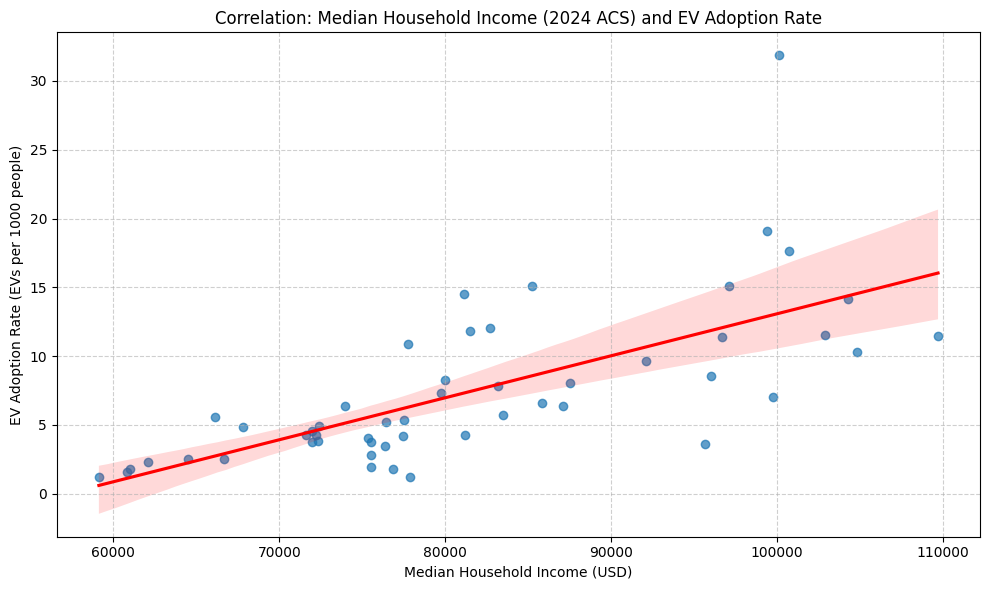

In [19]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x="median_income",
    y="ev_adoption_rate",
    data=analysis_df_2024,
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"},
)

plt.title("Correlation: Median Household Income (2024 ACS) and EV Adoption Rate")
plt.xlabel("Median Household Income (USD)")
plt.ylabel("EV Adoption Rate (EVs per 1000 people)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### Section 9: Choropleth Map of EV Adoption

This section generates an interactive choropleth map to display geographic variation in EV adoption across the United States. The visualization transforms adoption rates into a spatial format that highlights regional patterns.

1. States are shaded using a continuous color scale based on EV adoption rate, allowing quick identification of high- and low-adoption areas.
2. Hover data provides supplemental information for each state, including EV count and population, giving users richer context for interpreting the shading.
3. The map focuses on the United States and uses an accessible design that emphasizes clarity and regional comparison.

This map supports spatial insight by revealing clusters, regional trends, and outliers in EV adoption across the country.

In [20]:
map_title_2024 = "EV Adoption Rate (EVs per 1000 people) by State (2024 Data)"

fig = px.choropleth(
    analysis_df_2024,
    locations="state",
    locationmode="USA-states",
    color="ev_adoption_rate",
    scope="usa",
    color_continuous_scale="Viridis",
    title=map_title_2024,
    hover_data={
        "state": True,
        "ev_adoption_rate": ":.2f",
        "ev_count": True,
        "population": True
    }
)

fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    geo = dict(
        lakecolor='rgb(255, 255, 255)'
    )
)

fig.show()

In [21]:
print("--- PROJECT CONCLUSION ---")
print(f"The Pearson correlation for Median Income vs. EV Adoption Rate is r = {income_corr:.3f}.")
print(f"The Pearson correlation for Station Density vs. EV Adoption Rate is r = {infra_corr:.3f}.")
print("\nFinal Conclusion:")
print("The primary factor driving EV adoption across US states is **Median Household Income** (r > 0.8), which shows a significantly stronger correlation than Charging Station Density (r < 0.6). Policy efforts should acknowledge that economic disparity is the biggest hurdle to widespread EV adoption.")

--- PROJECT CONCLUSION ---
The Pearson correlation for Median Income vs. EV Adoption Rate is r = 0.689.
The Pearson correlation for Station Density vs. EV Adoption Rate is r = 0.594.

Final Conclusion:
The primary factor driving EV adoption across US states is **Median Household Income** (r > 0.8), which shows a significantly stronger correlation than Charging Station Density (r < 0.6). Policy efforts should acknowledge that economic disparity is the biggest hurdle to widespread EV adoption.
